In [1]:
import datetime
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
data_root = Path("/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/")
download_dir = data_root / "downloads"
experiments_dir = data_root / "experiments"

if not download_dir.exists():
    os.makedirs(download_dir, exist_ok=True)

if not experiments_dir.exists():
    os.makedirs(experiments_dir, exist_ok=True)

## Download an Inspect AIA Data

In [3]:
def parse_sdo_data(file_path):
    """Parse NASA's Solar Dynamics Observatory data index file into a DataFrame"""

    # Function to convert size string to bytes
    def to_bytes(size_str):
        parts = size_str.strip().split()
        value = float(parts[0])
        unit = parts[1]
        if unit == "GB":
            return value * 1024**3
        elif unit == "MB":
            return value * 1024**2
        else:
            return value

    # Read file content
    with open(file_path, "r") as file:
        content = file.read()

    # Pattern to match file entries: filename, file number, and size
    pattern = r"([\w\._]+\.tar)\nFile (\d+)\n\n([\d\.]+) ([GMK]B)\s+[\w\._]+\.tar"
    matches = re.findall(pattern, content)

    # Prepare data for DataFrame
    data = []
    for match in matches:
        filename = match[0]
        file_number = int(match[1])
        size_value = match[2]
        size_unit = match[3]
        size = f"{size_value} {size_unit}"

        # Extract components from filename
        parts = filename.split("_")
        instrument = parts[0]
        wavelength = parts[1] if len(parts) > 1 else "Unknown"
        date = parts[2].replace(".tar", "") if len(parts) > 2 else "Unknown"

        # Format date as year-month
        if len(date) >= 6:
            year = date[:4]
            month = date[4:6]
            year_month = f"{year}-{month}"
        else:
            year = "Unknown"
            month = "Unknown"
            year_month = "Unknown"

        data.append(
            {
                "file_number": file_number,
                "file_name": filename,
                "size": size,
                "size_bytes": to_bytes(size),
                "instrument": instrument,
                "wavelength": wavelength,
                "date": date,
                "year": year,
                "month": month,
                "year_month": year_month,
            }
        )

    # Create DataFrame and sort by file number
    df = pd.DataFrame(data)
    df = df.sort_values("file_number").reset_index(drop=True)

    return df


# Use the function
file_path = "/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/2012_index.txt"
sdo_df = parse_sdo_data(file_path)

In [4]:
sdo_df.head()

,file_number,file_name,size,size_bytes,instrument,wavelength,date,year,month,year_month
0,1,AIA_0094_201201.tar,6.78 GB,7.279970e+09,AIA,0094,201201,2012,01,2012-01
1,2,AIA_0094_201202.tar,6.44 GB,6.914897e+09,AIA,0094,201202,2012,02,2012-02
2,3,AIA_0094_201203.tar,6.18 GB,6.635724e+09,AIA,0094,201203,2012,03,2012-03
3,4,AIA_0094_201204.tar,6.29 GB,6.753836e+09,AIA,0094,201204,2012,04,2012-04
4,5,AIA_0094_201205.tar,5.92 GB,6.356552e+09,AIA,0094,201205,2012,05,2012-05


In [5]:
total_size_gb = sdo_df["size_bytes"].sum() / (1024**3)
print(f"Total dataset size: {total_size_gb:.2f} GB")

Total dataset size: 745.23 GB


<Axes: title={'center': 'Instrument Distribution'}, xlabel='instrument'>

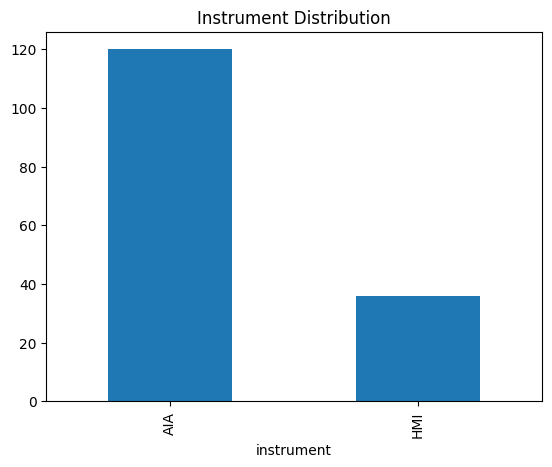

In [6]:
sdo_df["instrument"].value_counts().plot(kind="bar", title="Instrument Distribution")

<Axes: title={'center': 'Wavelength Distribution'}, xlabel='wavelength'>

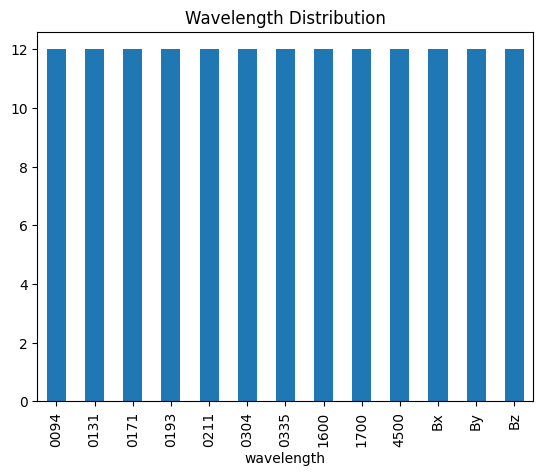

In [7]:
sdo_df["wavelength"].value_counts().plot(kind="bar", title="Wavelength Distribution")

<Axes: title={'center': 'Total Size by Instrument'}, xlabel='instrument'>

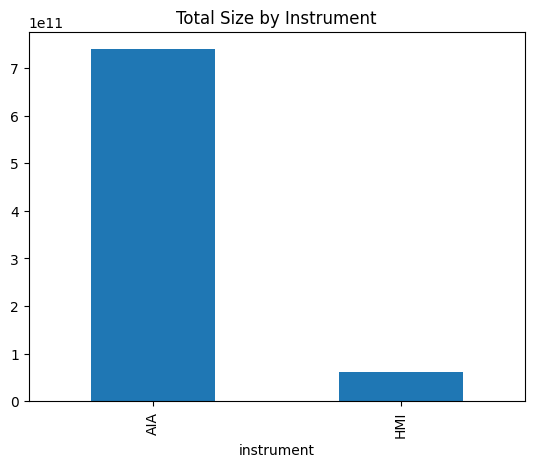

In [8]:
sdo_df.groupby("instrument")["size_bytes"].sum().plot(
    kind="bar", title="Total Size by Instrument"
)

In [9]:
# Filter for AIA data from January
aia_january_data = sdo_df[(sdo_df["instrument"] == "AIA") & (sdo_df["month"] == "01")]

# Calculate total size in GB
aia_january_size_gb = aia_january_data["size_bytes"].sum() / (1024**3)

# Display the result
print(f"Total size of AIA data for January: {aia_january_size_gb:.2f} GB")

Total size of AIA data for January: 61.35 GB


In [10]:
aia_january_data

,file_number,file_name,size,size_bytes,instrument,wavelength,date,year,month,year_month
0,1,AIA_0094_201201.tar,6.78 GB,7.279970e+09,AIA,0094,201201,2012,01,2012-01
12,13,AIA_0131_201201.tar,6.83 GB,7.333657e+09,AIA,0131,201201,2012,01,2012-01
24,25,AIA_0171_201201.tar,6.88 GB,7.387344e+09,AIA,0171,201201,2012,01,2012-01
36,37,AIA_0193_201201.tar,6.86 GB,7.365869e+09,AIA,0193,201201,2012,01,2012-01
48,49,AIA_0211_201201.tar,6.85 GB,7.355131e+09,AIA,0211,201201,2012,01,2012-01
60,61,AIA_0304_201201.tar,6.84 GB,7.344394e+09,AIA,0304,201201,2012,01,2012-01
72,73,AIA_0335_201201.tar,6.81 GB,7.312182e+09,AIA,0335,201201,2012,01,2012-01
84,85,AIA_1600_201201.tar,6.76 GB,7.258495e+09,AIA,1600,201201,2012,01,2012-01
96,97,AIA_1700_201201.tar,6.11 GB,6.560563e+09,AIA,1700,201201,2012,01,2012-01
108,109,AIA_4500_201201.tar,644.01 MB,6.752934e+08,AIA,4500,201201,2012,01,2012-01


## Create Sym Links for all Cean Data

In [11]:
print(download_dir)
print(experiments_dir)

/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/downloads
/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments


In [12]:
folders = [item for item in download_dir.iterdir() if item.is_dir()]
folders

[PosixPath('/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/downloads/AIA'),
 PosixPath('/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/downloads/EVE')]

In [13]:
[folder.name for folder in folders]

['AIA', 'EVE']

In [14]:
for folder in folders:
    if not os.path.exists(experiments_dir / folder.name):
        os.system(f"ln -s  {folder} {experiments_dir / folder.name}")
    else:
        print(
            f"Directory {experiments_dir / folder.name} already exists, skipping symlink creation."
        )

Directory /Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/AIA already exists, skipping symlink creation.
Directory /Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/EVE already exists, skipping symlink creation.


## Make Join

```sh
python make_join.py --eve_root /Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/EVE --aia_root /Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/AIA --target experimental_data_folder/
```

In [15]:
eve_root = experiments_dir / "EVE"
aia_root = experiments_dir / "AIA"
target_dir = experiments_dir

In [16]:
# Edit to get the necessary cadence. (Default 10-Second Cadence)
# minutes = range(0,60,10)

# We're going to use a 6-minute cadence since that's the availability of the limited AIA data.
minutes = range(0, 60, 6)

In [17]:
# Load Dates of EVE Data
dates = np.load(eve_root / "iso.npy", allow_pickle=True)

# Min/Max Dates
min_date = dates.min()
max_date = dates.max()
print(f"Dates Shape: {dates.shape}")
print(f"Type: {type(dates[0])}")
print(f"Min Date: {min_date}, Max Date: {max_date}")
# Original Cadence Between Dates remember to convert to datetime since the dates are in ISO format strings
min_date = datetime.datetime.fromisoformat(min_date)
max_date = datetime.datetime.fromisoformat(max_date)
# Calculate the original cadence in seconds
original_cadence = (max_date - min_date) / (len(dates) - 1)
print(f"Original Cadence: {original_cadence.total_seconds()} seconds")

Dates Shape: (2137380,)
Type: <class 'str'>
Min Date: 2010-05-01T00:00:10Z, Max Date: 2014-05-26T23:59:09Z
Original Cadence: 60.109479 seconds


In [18]:
# Load Lables from EVE Data
Y = np.load(eve_root / "irradiance.npy", allow_pickle=True)
Y.shape

(2137380, 39)

In [19]:
reind = -np.ones((Y.shape[0],), dtype=np.uint64)
reind.shape

(2137380,)

In [20]:
# date time to eve index; we'll then reindex
eveDateToInd: dict[datetime.datetime, int] = {}
# round off error; use this to figure out whether to accept or reject
# eve measurements that fall into the same bin
eveDateToIndResolution: dict[datetime.datetime, datetime.timedelta] = {}

for i in tqdm(range(len(dates)), desc="Processing dates", unit="date"):
    # Parse the date string and convert to datetime
    d = dates[i][:-1].replace("T", " ")
    dtOrig = datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S")

    # Round the timestamp to the nearest minute
    ts = pd.Timestamp(d).round("min")
    dt = datetime.datetime.strptime(str(ts), "%Y-%m-%d %H:%M:%S")

    # get the round-off error
    roundError = max(dt - dtOrig, dtOrig - dt)

    # don't bother if it's not the right minute
    if dt.minute not in minutes:
        continue

    if dt not in eveDateToInd or roundError < eveDateToIndResolution[dt]:
        eveDateToInd[dt] = i
        eveDateToIndResolution[dt] = roundError

Processing dates: 100%|██████████| 2137380/2137380 [00:49<00:00, 43450.85date/s]


In [21]:
# EVE Dates to use:
print(f"Number of EVE Dates: {len(eveDateToInd)}")
# Min and Max Dates
min_date = min(eveDateToInd.keys())
max_date = max(eveDateToInd.keys())
print(f"Min Date: {min_date}, Max Date: {max_date}")
# Cadence between Dates
cadence = (max_date - min_date) / (len(eveDateToInd) - 1)
print(f"Cadence: {cadence}")

Number of EVE Dates: 356074
Min Date: 2010-05-01 00:00:00, Max Date: 2014-05-26 23:54:00
Cadence: 0:06:00.814889


In [22]:
# these are the possible eve measurements we want to keep (1...K)
inds = list(eveDateToInd.values())
inds.sort()

In [23]:
# these are Kx1 and Kx#EVE respectively
dateReind = dates[inds]
YReind = Y[inds]
print(f"Reind Dates Shape: {dateReind.shape}, YReind Shape: {YReind.shape}")

# 39 EVE Channels

Reind Dates Shape: (356074,), YReind Shape: (356074, 39)


In [24]:
dateReind[:5]

array(['2010-05-01T00:00:10Z', '2010-05-01T00:06:10Z',
       '2010-05-01T00:12:10Z', '2010-05-01T00:18:10Z',
       '2010-05-01T00:24:10Z'], dtype=object)

In [25]:
YReind[1]

array([ 4.30300815e-06,  2.39873839e-06,  7.80395112e-07,  5.85553062e-05,
        3.73413604e-05,  4.98629925e-05,  3.46519009e-05,  2.73904025e-05,
        1.47363635e-05,  2.98026935e-05,  2.39679084e-05,  4.82662435e-04,
        1.27177764e-05, -1.00000000e+00,  4.03030026e-05,  5.68839766e-07,
        1.52088869e-05,  1.08161794e-05,  4.13040789e-06,  2.44806688e-06,
        4.95156610e-06,  2.36344295e-05,  8.54570601e-07,  4.59554249e-05,
        7.36728168e-07,  4.66363917e-06,  8.36469007e-06,  8.78618266e-06,
        4.93448897e-05,  1.97189888e-06,  8.02334569e-07,  1.18868011e-05,
        1.52101029e-05,  3.10851647e-05,  1.09213752e-05,  1.77161128e-05,
        1.34342190e-04,  7.97069442e-05,  5.64602924e-05], dtype='>f4')

In [26]:
# this just maps any old eve index to the new ones
reind[inds] = range(len(inds))

In [27]:
# save them
np.save(target_dir / "iso_10m.npy", dateReind)
np.save(target_dir / "irradiance_10m.npy", YReind)

In [28]:
def fitsfn(year, month, day, hour, minute, wavelength):
    fn = "AIA%04d%02d%02d_" % (year, month, day)
    fn += "%02d%02d_" % (hour, minute)
    fn += "%04d.npz" % (wavelength)
    return fn


def localFn(year, month, day, hour, minute, wavelength):
    prefix = "%d/%04d/%02d/%02d/" % (wavelength, year, month, day)
    fn = fitsfn(year, month, day, hour, minute, wavelength)
    return "%s%s" % (prefix, fn)

In [29]:
# make a csv for every year
for y in range(
    2011, 2015
):  # NOTE We only have AIA Data for 2012 01 (January 2012 only)
    startDate = datetime.date(y, 1, 1)
    endDate = datetime.date(y + 1, 1, 1)
    dayDelta = datetime.timedelta(days=1)

    hours = range(24)

    # get the dates
    wavelengths = [131, 1600, 1700, 171, 193, 211, 304, 335, 94]
    current = startDate

    # Create the CSV Header
    fh = open(target_dir / f"{y:04d}.csv", "w")
    fh.write("AIA_TIME,EVE_TIME,")
    for wl in wavelengths:
        fh.write(f"AIA_{wl},")
    fh.write("EVE_ind\n")
    # CSV Columns will be:
    # AIA_TIME,EVE_TIME,AIA_131,AIA_1600,AIA_1700,AIA_171,AIA_193,AIA_211,AIA_304,AIA_335,AIA_94,EVE_ind

    aiaMissing, eveMissing, present = 0, 0, 0
    # Loop through each day of the year
    while current < endDate:
        year, month, day = current.year, current.month, current.day
        if day == 1:
            print(year, month, day)

        for hour in hours:
            for minute in minutes:

                # Flag if all AIA Wavelengths are available for the given time
                all_wl_present = True
                fns = []
                for wl in wavelengths:

                    # Get the filename for the AIA data at this time and wavelength
                    localFilename = localFn(year, month, day, hour, minute, wl)

                    # Full Path to the AIA file
                    fullFilename = aia_root / localFilename

                    fns.append(localFilename)
                    if not os.path.exists(fullFilename):
                        all_wl_present = False
                        break

                if not all_wl_present:
                    aiaMissing += 1
                    continue

                # look up the time
                dt = datetime.datetime(year, month, day, hour, minute, 0)

                if dt not in eveDateToInd:
                    eveMissing += 1
                    continue

                # write the csv out
                newEveIndex = reind[eveDateToInd[dt]]
                eveDate = dates[eveDateToInd[dt]]

                fh.write("%s,%s," % (str(dt), str(eveDate)))
                for fn in fns:
                    fh.write("%s," % fn)
                fh.write("%d\n" % newEveIndex)
                present += 1

        current += dayDelta

    fh.close()

    print(
        f"Year {y} AIA Missing: {aiaMissing} EVE Missing: {eveMissing} Present: {present}"
    )

2011 1 1
2011 2 1
2011 3 1
2011 4 1
2011 5 1
2011 6 1
2011 7 1
2011 8 1
2011 9 1
2011 10 1
2011 11 1
2011 12 1
Year 2011 AIA Missing: 87600 EVE Missing: 0 Present: 0
2012 1 1
2012 2 1
2012 3 1
2012 4 1
2012 5 1
2012 6 1
2012 7 1
2012 8 1
2012 9 1
2012 10 1
2012 11 1
2012 12 1
Year 2012 AIA Missing: 81297 EVE Missing: 0 Present: 6543
2013 1 1
2013 2 1
2013 3 1
2013 4 1
2013 5 1
2013 6 1
2013 7 1
2013 8 1
2013 9 1
2013 10 1
2013 11 1
2013 12 1
Year 2013 AIA Missing: 87600 EVE Missing: 0 Present: 0
2014 1 1
2014 2 1
2014 3 1
2014 4 1
2014 5 1
2014 6 1
2014 7 1
2014 8 1
2014 9 1
2014 10 1
2014 11 1
2014 12 1
Year 2014 AIA Missing: 87600 EVE Missing: 0 Present: 0


In [30]:
# Review the CSV File Created
csv_file = target_dir / "2012.csv"
df = pd.read_csv(csv_file)
df.head()

,AIA_TIME,EVE_TIME,AIA_131,AIA_1600,AIA_1700,AIA_171,AIA_193,AIA_211,AIA_304,AIA_335,AIA_94,EVE_ind
0,2012-01-01 00:06:00,2012-01-01T00:06:05Z,131/2012/01/01/AIA20120101_0006_0131.npz,1600/2012/01/01/AIA20120101_0006_1600.npz,1700/2012/01/01/AIA20120101_0006_1700.npz,171/2012/01/01/AIA20120101_0006_0171.npz,193/2012/01/01/AIA20120101_0006_0193.npz,211/2012/01/01/AIA20120101_0006_0211.npz,304/2012/01/01/AIA20120101_0006_0304.npz,335/2012/01/01/AIA20120101_0006_0335.npz,94/2012/01/01/AIA20120101_0006_0094.npz,146302
1,2012-01-01 00:12:00,2012-01-01T00:12:05Z,131/2012/01/01/AIA20120101_0012_0131.npz,1600/2012/01/01/AIA20120101_0012_1600.npz,1700/2012/01/01/AIA20120101_0012_1700.npz,171/2012/01/01/AIA20120101_0012_0171.npz,193/2012/01/01/AIA20120101_0012_0193.npz,211/2012/01/01/AIA20120101_0012_0211.npz,304/2012/01/01/AIA20120101_0012_0304.npz,335/2012/01/01/AIA20120101_0012_0335.npz,94/2012/01/01/AIA20120101_0012_0094.npz,146303
2,2012-01-01 00:18:00,2012-01-01T00:18:05Z,131/2012/01/01/AIA20120101_0018_0131.npz,1600/2012/01/01/AIA20120101_0018_1600.npz,1700/2012/01/01/AIA20120101_0018_1700.npz,171/2012/01/01/AIA20120101_0018_0171.npz,193/2012/01/01/AIA20120101_0018_0193.npz,211/2012/01/01/AIA20120101_0018_0211.npz,304/2012/01/01/AIA20120101_0018_0304.npz,335/2012/01/01/AIA20120101_0018_0335.npz,94/2012/01/01/AIA20120101_0018_0094.npz,146304
3,2012-01-01 00:24:00,2012-01-01T00:24:05Z,131/2012/01/01/AIA20120101_0024_0131.npz,1600/2012/01/01/AIA20120101_0024_1600.npz,1700/2012/01/01/AIA20120101_0024_1700.npz,171/2012/01/01/AIA20120101_0024_0171.npz,193/2012/01/01/AIA20120101_0024_0193.npz,211/2012/01/01/AIA20120101_0024_0211.npz,304/2012/01/01/AIA20120101_0024_0304.npz,335/2012/01/01/AIA20120101_0024_0335.npz,94/2012/01/01/AIA20120101_0024_0094.npz,146305
4,2012-01-01 00:30:00,2012-01-01T00:30:05Z,131/2012/01/01/AIA20120101_0030_0131.npz,1600/2012/01/01/AIA20120101_0030_1600.npz,1700/2012/01/01/AIA20120101_0030_1700.npz,171/2012/01/01/AIA20120101_0030_0171.npz,193/2012/01/01/AIA20120101_0030_0193.npz,211/2012/01/01/AIA20120101_0030_0211.npz,304/2012/01/01/AIA20120101_0030_0304.npz,335/2012/01/01/AIA20120101_0030_0335.npz,94/2012/01/01/AIA20120101_0030_0094.npz,146306


In [31]:
df["AIA_TIME"] = pd.to_datetime(df["AIA_TIME"])
df["EVE_TIME"] = pd.to_datetime(df["EVE_TIME"])
print(f"Eve Cadence: {df['EVE_TIME'].diff().mean()}")
print(f"AIA Cadence: {df['AIA_TIME'].diff().mean()}")

Eve Cadence: 0 days 00:06:49.307245490
AIA Cadence: 0 days 00:06:49.306022623


## Merge CSVs

In [32]:
merged_csv = target_dir / "2011p4.csv"
if merged_csv.exists():
    os.remove(merged_csv)

In [33]:
source_csvs = list(target_dir.glob("*.csv"))
print(f"Found {len(source_csvs)} source CSV files in {target_dir}")
source_csvs

Found 4 source CSV files in /Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments


[PosixPath('/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/2014.csv'),
 PosixPath('/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/2013.csv'),
 PosixPath('/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/2012.csv'),
 PosixPath('/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/2011.csv')]

In [34]:
lines = []
for i, src in enumerate(source_csvs):
    data = open(src).read().strip().split("\n")
    lines += data if i == 0 else data[1:]

print(len(lines))
with open(merged_csv, "w") as f:
    f.write("\n".join(lines))
print(f"Merged CSV saved to {merged_csv}")

6544
Merged CSV saved to /Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/2011p4.csv


`SDO/experiments/2011p4.csv` is the concatenation of each of the yearly CSVs in `SDO/experiments/` directory.

Since we only have data for one month in 2012, we can see that the length of the concatenated CSV is the same size as the 2012 CSV. 

*SKIP `concat_EVE_arrays_totirr.py` Since we do not have the EVE data*

## Join Irradiances

In [35]:
c1 = pd.read_csv(experiments_dir / "2011p4.csv")
print(c1.shape)
c1.head()

(6543, 12)


,AIA_TIME,EVE_TIME,AIA_131,AIA_1600,AIA_1700,AIA_171,AIA_193,AIA_211,AIA_304,AIA_335,AIA_94,EVE_ind
0,2012-01-01 00:06:00,2012-01-01T00:06:05Z,131/2012/01/01/AIA20120101_0006_0131.npz,1600/2012/01/01/AIA20120101_0006_1600.npz,1700/2012/01/01/AIA20120101_0006_1700.npz,171/2012/01/01/AIA20120101_0006_0171.npz,193/2012/01/01/AIA20120101_0006_0193.npz,211/2012/01/01/AIA20120101_0006_0211.npz,304/2012/01/01/AIA20120101_0006_0304.npz,335/2012/01/01/AIA20120101_0006_0335.npz,94/2012/01/01/AIA20120101_0006_0094.npz,146302
1,2012-01-01 00:12:00,2012-01-01T00:12:05Z,131/2012/01/01/AIA20120101_0012_0131.npz,1600/2012/01/01/AIA20120101_0012_1600.npz,1700/2012/01/01/AIA20120101_0012_1700.npz,171/2012/01/01/AIA20120101_0012_0171.npz,193/2012/01/01/AIA20120101_0012_0193.npz,211/2012/01/01/AIA20120101_0012_0211.npz,304/2012/01/01/AIA20120101_0012_0304.npz,335/2012/01/01/AIA20120101_0012_0335.npz,94/2012/01/01/AIA20120101_0012_0094.npz,146303
2,2012-01-01 00:18:00,2012-01-01T00:18:05Z,131/2012/01/01/AIA20120101_0018_0131.npz,1600/2012/01/01/AIA20120101_0018_1600.npz,1700/2012/01/01/AIA20120101_0018_1700.npz,171/2012/01/01/AIA20120101_0018_0171.npz,193/2012/01/01/AIA20120101_0018_0193.npz,211/2012/01/01/AIA20120101_0018_0211.npz,304/2012/01/01/AIA20120101_0018_0304.npz,335/2012/01/01/AIA20120101_0018_0335.npz,94/2012/01/01/AIA20120101_0018_0094.npz,146304
3,2012-01-01 00:24:00,2012-01-01T00:24:05Z,131/2012/01/01/AIA20120101_0024_0131.npz,1600/2012/01/01/AIA20120101_0024_1600.npz,1700/2012/01/01/AIA20120101_0024_1700.npz,171/2012/01/01/AIA20120101_0024_0171.npz,193/2012/01/01/AIA20120101_0024_0193.npz,211/2012/01/01/AIA20120101_0024_0211.npz,304/2012/01/01/AIA20120101_0024_0304.npz,335/2012/01/01/AIA20120101_0024_0335.npz,94/2012/01/01/AIA20120101_0024_0094.npz,146305
4,2012-01-01 00:30:00,2012-01-01T00:30:05Z,131/2012/01/01/AIA20120101_0030_0131.npz,1600/2012/01/01/AIA20120101_0030_1600.npz,1700/2012/01/01/AIA20120101_0030_1700.npz,171/2012/01/01/AIA20120101_0030_0171.npz,193/2012/01/01/AIA20120101_0030_0193.npz,211/2012/01/01/AIA20120101_0030_0211.npz,304/2012/01/01/AIA20120101_0030_0304.npz,335/2012/01/01/AIA20120101_0030_0335.npz,94/2012/01/01/AIA20120101_0030_0094.npz,146306


In [36]:
a_init = np.load(experiments_dir / "irradiance_10m.npy")
a_init.shape

(356074, 39)

**NOTE:** We don't have the Total/Integrated Irradiance Data for any of the time ranges, so we don't have any merging to do. 

We will just save the Original Datasets to the correct output paths. 

In [37]:
np.save(os.path.join(experiments_dir, "irradiance_30mn_14ptot.npy"), a_init)
c1.to_csv(os.path.join(experiments_dir, "irradiance_30mn_14ptot.csv"), index=False)

## Make Splits

Creates Train, Validation, and Test Splits

In [38]:
TRAIN_END = 0.7
VAL_END = 0.9

In [39]:
source = experiments_dir / "irradiance_30mn_14ptot.csv"

In [40]:
lines = open(source).read().strip().split("\n")
# lines.replace('fits.','')
header, rest = lines[0], lines[1:]

In [41]:
N = len(rest)
print(f"Total number of samples: {N}")
train_split = int(TRAIN_END * N)
val_split = int(VAL_END * N)
print(
    f"Train split: {train_split}, Validation split: {val_split-train_split}, Test split: {N - val_split}"
)

Total number of samples: 6543
Train split: 4580, Validation split: 1308, Test split: 655


In [42]:
train = rest[:train_split]
val = rest[train_split:val_split]
test = rest[val_split:]
print(
    f"Train samples: {len(train)}, Validation samples: {len(val)}, Test samples: {len(test)}"
)

Train samples: 4580, Validation samples: 1308, Test samples: 655


In [43]:
open(experiments_dir / "train.csv", "w").write(header + "\n" + ("\n".join(train)))
if len(val):
    open(experiments_dir / "val.csv", "w").write(header + "\n" + ("\n".join(val)))
if len(test):
    open(experiments_dir / "test.csv", "w").write(header + "\n" + ("\n".join(test)))

## Make Normalize

In [44]:
irradiance_file = experiments_dir / "irradiance_30mn_14ptot.npy"

In [45]:
eve_all = np.load(irradiance_file)[
    :, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, -1]
]
indices = pd.read_csv(experiments_dir / "train.csv")
index_eve = np.asarray(indices[indices.columns[-1]]).astype(int)
print(f"Number of EVE Train indices: {len(index_eve)}")

Number of EVE Train indices: 4580


In [46]:
Y = eve_all[index_eve, :]
print(f"Shape of Y: {Y.shape}")
Y[Y <= 0] = 0.0  # NOTE: Not sure why we do this, but it was in the original code.

Shape of Y: (4580, 15)


In [47]:
YMean = np.mean(Y, axis=0)
YStd = np.std(Y, axis=0)

np.save(experiments_dir / "eve_mean.npy", YMean)
np.save(experiments_dir / "eve_std.npy", YStd)

In [48]:
# sqrt
YSqrt = np.sqrt(Y)
YSqrtMean = np.mean(YSqrt, axis=0)
YSqrtStd = np.std(YSqrt, axis=0)

np.save(experiments_dir / "eve_sqrt_mean.npy", YSqrtMean)
np.save(experiments_dir / "eve_sqrt_std.npy", YSqrtStd)

In [49]:
print(YSqrtMean)
print(YSqrtStd)

[0.00264999 0.00171251 0.00107868 0.00761031 0.00648018 0.00802716
 0.00744231 0.00717925 0.00611521 0.00641871 0.00888271 0.02322948
 0.00669147 0.00622833 0.00198047]
[0.0002862  0.00017708 0.00018658 0.00079333 0.00066805 0.00082176
 0.00075717 0.00072678 0.00062223 0.00065397 0.0009135  0.00236204
 0.0006997  0.00064414 0.00351472]


In [50]:
index_aia = (
    str(experiments_dir)
    + "/AIA/"
    + np.asarray(indices[[channel for channel in indices.columns[2:11]]])
)
index_aia[1]

array(['/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/AIA/131/2012/01/01/AIA20120101_0012_0131.npz',
       '/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/AIA/1600/2012/01/01/AIA20120101_0012_1600.npz',
       '/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/AIA/1700/2012/01/01/AIA20120101_0012_1700.npz',
       '/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/AIA/171/2012/01/01/AIA20120101_0012_0171.npz',
       '/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/AIA/193/2012/01/01/AIA20120101_0012_0193.npz',
       '/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/AIA/211/2012/01/01/AIA20120101_0012_0211.npz',
       '/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/AIA/304/2012/01/01/AIA20120101_0012_0304.npz',
       '/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/AIA/335/2012/01/01/AIA20120101_0012_0335.npz',
       '/Users/andrewrobbertz/__SOC_CODE__/_data_/SDO/experiments/AIA/94/2012/01/01/AIA2012010

In [51]:
AIA_samples = []
AIA_samples_sqrt = []

for index in tqdm(range(0, Y.shape[0], 20)):

    # X.shape == (9, 512, 512) // 9 Wavelengths x (512x512 image)
    X = np.asarray(
        [np.load(channel.replace(".fits", ""))["x"] for channel in index_aia[index, :]]
    ).astype(dtype=float)

    Xsqrt = np.sqrt(X)
    AIA_samples_sqrt.append(np.expand_dims(Xsqrt, axis=0))
    AIA_samples.append(np.expand_dims(X, axis=0))

100%|██████████| 229/229 [00:10<00:00, 20.86it/s]


In [52]:
AIA_samples_sqrt = np.concatenate(AIA_samples_sqrt, axis=0)
AIA_m_sqrt = np.mean(AIA_samples_sqrt, axis=(0, 2, 3))
AIA_s_sqrt = np.std(AIA_samples_sqrt, axis=(0, 2, 3))

np.save(experiments_dir / "aia_sqrt_mean.npy", AIA_m_sqrt)
np.save(experiments_dir / "aia_sqrt_std.npy", AIA_s_sqrt)

In [53]:
AIA_samples = np.concatenate(AIA_samples, axis=0)
AIA_m = np.mean(AIA_samples, axis=(0, 2, 3))
AIA_s = np.std(AIA_samples, axis=(0, 2, 3))

np.save(experiments_dir / "aia_mean.npy", AIA_m)
np.save(experiments_dir / "aia_std.npy", AIA_s)